In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import tqdm
import random
import glob
import json
import networkx as nx

In [2]:
ZAPPOS_ROOT = '/home/amrith/zappos-50k/'
ZAPPOS_IMAGES_ROOT = '/home/amrith/zappos-50k/ut-zap50k-images-square'

In [3]:
df = pd.read_csv(f'{ZAPPOS_ROOT}/ut-zap50k-data/meta-data-bin.csv')
df['HeelHeight.High.heel'] = df['HeelHeight.4in...4.3.4in'] + df['HeelHeight.5in...over']
df['HeelHeight.Short.heel'] = df['HeelHeight.Flat'] + df['HeelHeight.Under.1in'] + df['HeelHeight.1in...1.3.4in']

In [4]:
df.shape

(50025, 154)

In [5]:
print(sorted(df.columns))

['CID', 'Category.Boots', 'Category.Sandals', 'Category.Shoes', 'Category.Slippers', 'Closure.Adjustable', 'Closure.Ankle.Strap', 'Closure.Ankle.Wrap', 'Closure.Belt', 'Closure.Buckle', 'Closure.Bungee', 'Closure.Button.Loop', 'Closure.Elastic.Gore', 'Closure.Hook.and.Loop', 'Closure.Lace.up', 'Closure.Monk.Strap', 'Closure.Pull.on', 'Closure.Sling.Back', 'Closure.Slip.On', 'Closure.Snap', 'Closure.Spat.Strap', 'Closure.T.Strap', 'Closure.Toggle', 'Closure.Zipper', 'Gender.Boys', 'Gender.Girls', 'Gender.Men', 'Gender.Women', 'HeelHeight.1in...1.3.4in', 'HeelHeight.2in...2.3.4in', 'HeelHeight.3in...3.3.4in', 'HeelHeight.4in...4.3.4in', 'HeelHeight.5in...over', 'HeelHeight.Flat', 'HeelHeight.High.heel', 'HeelHeight.Short.heel', 'HeelHeight.Under.1in', 'Insole.EVA', 'Insole.Gel', 'Insole.Hypoallergenic', 'Insole.Latex.Lined', 'Insole.Leather', 'Insole.Memory.Foam', 'Insole.Moisture.Wicking', 'Insole.Orthotic.Friendly', 'Insole.Padded', 'Insole.Polyurethane', 'Insole.Poron', 'Insole.Remova

In [6]:
# Attribute list
ATTR_LIST_1 = ['Category.Shoes', 'Category.Sandals', 'SubCategory.Oxfords', 'SubCategory.Heel', 'SubCategory.Boot', 'SubCategory.Slipper.Flats', 'SubCategory.Flats', 'SubCategory.Slipper.Heels', 'SubCategory.Athletic', 'SubCategory.Knee.High', 'SubCategory.Crib.Shoes', 'SubCategory.Over.the.Knee', 'HeelHeight.High.heel', 'HeelHeight.Short.heel', 'Closure.Pull.on', 'Closure.Ankle.Strap', 'Closure.Zipper', 'Closure.Elastic.Gore', 'Closure.Sling.Back', 'Closure.Toggle', 'Closure.Snap', 'Closure.T.Strap', 'Closure.Spat.Strap', 'Gender.Men', 'Gender.Boys', 'Material.Rubber', 'Material.Wool', 'Material.Silk', 'Material.Aluminum', 'Material.Plastic', 'ToeStyle.Capped Toe', 'ToeStyle.Square Toe', 'ToeStyle.Snub Toe', 'ToeStyle.Bicycle Toe', 'ToeStyle.Open Toe', 'ToeStyle.Pointed Toe', 'ToeStyle.Almond', 'ToeStyle.Apron Toe', 'ToeStyle.Snip Toe', 'ToeStyle.Medallion']
ATTR_LIST_2 = ['Category.Boots', 'Category.Slippers', 'SubCategory.Mid.Calf', 'SubCategory.Ankle', 'SubCategory.Loafers', 'SubCategory.Boat.Shoes', 'SubCategory.Clogs.and.Mules', 'SubCategory.Sneakers.and.Athletic.Shoes', 'SubCategory.Heels', 'SubCategory.Prewalker', 'SubCategory.Prewalker.Boots', 'SubCategory.Firstwalker', 'Closure.Lace.up', 'Closure.Buckle', 'Closure.Hook.and.Loop', 'Closure.Slip.On', 'Closure.Ankle.Wrap', 'Closure.Bungee', 'Closure.Adjustable',  'Closure.Button.Loop', 'Closure.Monk.Strap', 'Closure.Belt', 'Gender.Women', 'Gender.Girls', 'Material.Suede', 'Material.Snakeskin', 'Material.Corduroy', 'Material.Horse.Hair', 'Material.Stingray', 'ToeStyle.Round Toe', 'ToeStyle.Closed Toe', 'ToeStyle.Moc Toe', 'ToeStyle.Wingtip', 'ToeStyle.Center Seam', 'ToeStyle.Algonquin', 'ToeStyle.Bump Toe', 'ToeStyle.Wide Toe Box', 'ToeStyle.Peep Toe']
FULL_ATTR_LIST = sorted(list(set(ATTR_LIST_1 + ATTR_LIST_2)))
for x in FULL_ATTR_LIST:
    if x not in df.columns: 
        print(x)
print(len(FULL_ATTR_LIST))

78


In [7]:
for a, x in zip(FULL_ATTR_LIST, df.loc[:, FULL_ATTR_LIST].apply(sum, axis=0)):
    if x<20:
        print(f'{a} \t\t {x}')

Closure.Adjustable 		 1
Closure.Belt 		 8
Material.Aluminum 		 14
Material.Horse.Hair 		 4
Material.Plastic 		 3
Material.Snakeskin 		 13
Material.Stingray 		 4
SubCategory.Athletic 		 14
SubCategory.Boot 		 14
SubCategory.Prewalker.Boots 		 2
SubCategory.Slipper.Heels 		 10


([<matplotlib.axis.XTick at 0x7fdbfa6c48d0>,
 <a list of 10 Text xticklabel objects>)

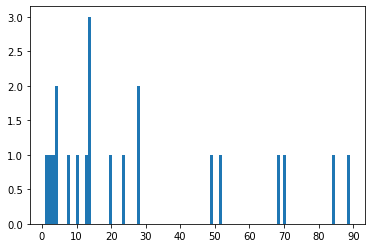

In [8]:
import matplotlib.pyplot as plt
plt.hist([x for x in df.loc[:, FULL_ATTR_LIST].apply(sum, axis=0).values if x < 100],bins=100)
plt.xticks(np.arange(0, 100, step=10),size=10)

In [9]:
def is_same_category(attrs):
    return len(set([attr.lower().split(".")[0] for attr in attrs])) < len(attrs)
    
def get_all_positive_images(df, attrs):
    return df[attrs].apply(sum, axis=1) == len(attrs)

In [10]:
# from tqdm import tqdm
# import concurrent.futures
# from multiprocessing import Pool

# attr_pairs = []
# for i in range(len(FULL_ATTR_LIST)):        
#     for j in range(i+1, len(FULL_ATTR_LIST)):
#         attrs = sorted([FULL_ATTR_LIST[i], FULL_ATTR_LIST[j]]) # sort to fix key for pair of attrs
#         attr_pairs.append(attrs)

# print(len(attr_pairs)) # list of all attr pairs

# def get_positive_images_count(attrs):
#     if is_same_category(attrs):
#         return 0 # same category => 0 weight
#     else:
#         return get_all_positive_images(df, attrs).sum()

# pool = Pool() 
# counts = pool.map(get_positive_images_count, attr_pairs)

# attr_pair_weight = defaultdict(int)
# for a_pair, cnt in zip(attr_pairs, counts):
#     attr_pair_weight[";".join(a_pair)] = cnt 

In [11]:
import json
attr_pair_weight = json.load(open('attr_pair_weight.json', 'r'))

In [12]:
attr_pair_weight

{'Category.Boots;Category.Sandals': 0,
 'Category.Boots;Category.Shoes': 0,
 'Category.Boots;Category.Slippers': 0,
 'Category.Boots;Closure.Adjustable': 0,
 'Category.Boots;Closure.Ankle.Strap': 0,
 'Category.Boots;Closure.Ankle.Wrap': 0,
 'Category.Boots;Closure.Belt': 8,
 'Category.Boots;Closure.Buckle': 370,
 'Category.Boots;Closure.Bungee': 248,
 'Category.Boots;Closure.Button.Loop': 82,
 'Category.Boots;Closure.Elastic.Gore': 473,
 'Category.Boots;Closure.Hook.and.Loop': 429,
 'Category.Boots;Closure.Lace.up': 3613,
 'Category.Boots;Closure.Monk.Strap': 0,
 'Category.Boots;Closure.Pull.on': 4496,
 'Category.Boots;Closure.Sling.Back': 0,
 'Category.Boots;Closure.Slip.On': 16,
 'Category.Boots;Closure.Snap': 45,
 'Category.Boots;Closure.Spat.Strap': 19,
 'Category.Boots;Closure.T.Strap': 0,
 'Category.Boots;Closure.Toggle': 248,
 'Category.Boots;Closure.Zipper': 4484,
 'Category.Boots;Gender.Boys': 904,
 'Category.Boots;Gender.Girls': 1840,
 'Category.Boots;Gender.Men': 2800,
 'Cat

In [13]:
G = nx.Graph()
for node in FULL_ATTR_LIST:
    G.add_node(node)
for a_pair, wt in attr_pair_weight.items():
    a_1, a_2 = a_pair.split(";")
    if wt >= 20:
        G.add_edge(a_1, a_2, weight=wt)
print(f'no of connected components: {len(list(nx.connected_components(G)))}')
nodes_to_remove = []
for comp in sorted(nx.connected_components(G), key = len, reverse=True):
    if len(comp) <= 1:
        nodes_to_remove += comp

no of connected components: 13


In [14]:
UPDATED_ATTR_LIST = [x for x in FULL_ATTR_LIST if x not in nodes_to_remove]
print(len(UPDATED_ATTR_LIST))

66


In [15]:
# add nodes from UPDATED_ATTR_LIST
G = nx.Graph()
for node in UPDATED_ATTR_LIST:
    G.add_node(node)

# add edges
for a_pair, wt in attr_pair_weight.items():
    a_1, a_2 = a_pair.split(";")
    if a_1 in UPDATED_ATTR_LIST and a_2 in UPDATED_ATTR_LIST:
        if wt >= 20:
            G.add_edge(a_1, a_2, weight=1)   

In [16]:
len(G.edges())

773

In [17]:
def get_cut_val(G, subset):
    cut_val = 0
    cnt = 0
    not_subset = set(G.nodes).difference(set(subset))
    for a_node in subset:
        for b_node in not_subset:
            if G.get_edge_data(a_node, b_node):
                cut_val += G.get_edge_data(a_node, b_node)['weight']
#                 print(a_node, b_node, G.get_edge_data(a_node, b_node)['weight'])
                cnt += 1
    return cut_val, cnt

def get_subset_val(G, subset):
    val = 0
    cnt = 0
    for a_node in subset:
        for b_node in subset:
            if G.get_edge_data(a_node, b_node) is not None:
                val += G.get_edge_data(a_node, b_node)['weight']
#                 print(a_node, b_node, G.get_edge_data(a_node, b_node)['weight'])
                cnt += 1
    return val/2, cnt/2

In [18]:
# partition = nx.algorithms.community.kernighan_lin.kernighan_lin_bisection(G, max_iter=1000)

In [19]:
# random_permutation = np.random.permutation(G.nodes)
# random_partition = (random_permutation[:33], random_permutation[33:])

In [20]:
from sklearn.cluster import SpectralClustering
from collections import Counter
adj_mat = nx.to_numpy_matrix(G)
sc = SpectralClustering(2, affinity='precomputed', n_init=1000)
sc.fit(adj_mat)
Counter(sc.labels_)

Counter({0: 36, 1: 30})

In [21]:
sc.labels_

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
      dtype=int32)

In [22]:
sc_partition = np.array(G.nodes)[np.where(sc.labels_==1)[0]]
not_sc_partition = np.array(G.nodes)[np.where(sc.labels_==0)[0]]

In [23]:
print(get_cut_val(G, sc_partition))
print(get_subset_val(G, sc_partition))
print(get_subset_val(G, not_sc_partition))

(305, 305)
(153.0, 153.0)
(315.0, 315.0)


In [24]:
sc_partition

array(['Category.Shoes', 'Category.Slippers', 'Closure.Hook.and.Loop',
       'Closure.Lace.up', 'Closure.Monk.Strap', 'Closure.Slip.On',
       'Gender.Boys', 'Gender.Men', 'Material.Corduroy', 'Material.Silk',
       'Material.Wool', 'SubCategory.Boat.Shoes',
       'SubCategory.Crib.Shoes', 'SubCategory.Firstwalker',
       'SubCategory.Loafers', 'SubCategory.Oxfords',
       'SubCategory.Prewalker', 'SubCategory.Slipper.Flats',
       'SubCategory.Sneakers.and.Athletic.Shoes', 'ToeStyle.Algonquin',
       'ToeStyle.Apron Toe', 'ToeStyle.Bicycle Toe', 'ToeStyle.Bump Toe',
       'ToeStyle.Capped Toe', 'ToeStyle.Medallion', 'ToeStyle.Moc Toe',
       'ToeStyle.Snub Toe', 'ToeStyle.Square Toe',
       'ToeStyle.Wide Toe Box', 'ToeStyle.Wingtip'], dtype='<U39')

In [25]:
assert len(set(list(sc_partition) + list(not_sc_partition))) == len(G.nodes)

In [26]:
print(len(list(sc_partition)))

30


In [27]:
print(len(list(not_sc_partition)))

36


In [28]:
save_partition = {
    'ID': list(not_sc_partition),
    'OOD' : list(sc_partition)
}

In [29]:
import json
json.dump(save_partition, open('zappos_attributes_ID_OOD_partition.json', 'w'))